In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ts_helper import *
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsaplots

# Load sunspots data

<AxesSubplot:xlabel='Date'>

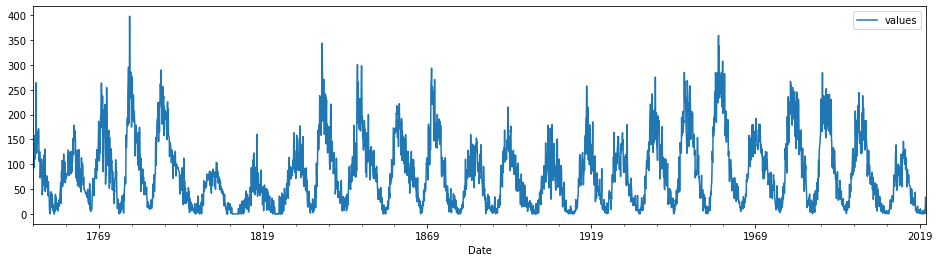

In [2]:
sunspots = pd.read_csv('Sunspots.csv')
sunspots = sunspots.set_index(pd.to_datetime(sunspots['Date'])) \
    .drop(columns=['Unnamed: 0','Date']) \
    .rename(columns={'Monthly Mean Total Sunspot Number':'values'})

sunspots.plot(figsize=(16,4))

# Split historical and future data

In [3]:
y_hist = sunspots.loc['1900':'1984','values']
y_future = sunspots.loc['1985':'2000','values']

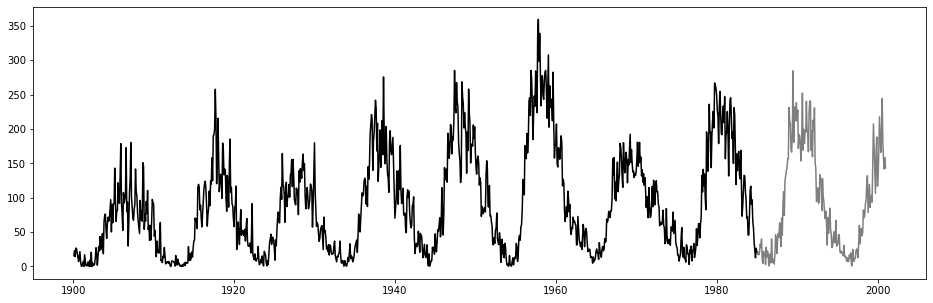

In [4]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k')
plt.plot(y_future,'k',alpha=0.5)

# Extract the trend

In [5]:
period = 128

filt = np.ones(period+1)
filt[0] = 0.5
filt[-1] = 0.5
filt /= period

In [6]:
trend = convolution_filter(y_hist, filt)
trend = extrapolate_trend(trend, period + 1)

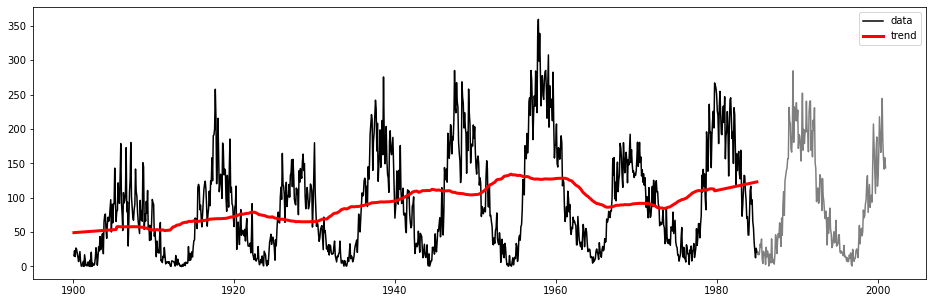

In [7]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data')
plt.plot(trend,'r',linewidth=3,label='trend')
plt.plot(y_future,'k',alpha=0.5)
plt.legend()

# Detrended data

In [8]:
detrended = y_hist - trend
detrended = detrended.to_numpy()

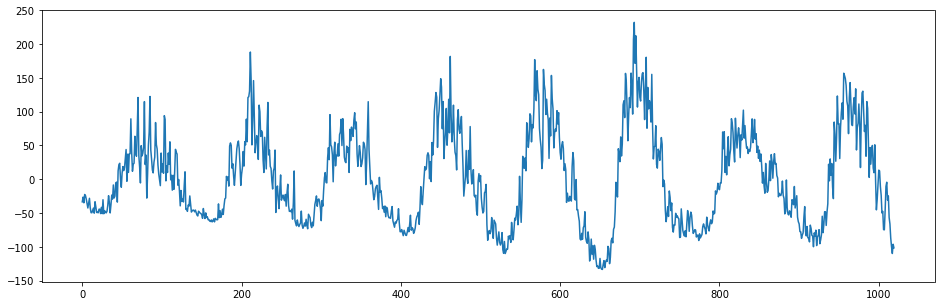

In [9]:
plt.figure(figsize=(16,5))
plt.plot(detrended)

# Split the historical data into seasons

In [10]:
lows_index = [20,155,284,405,529,650,775,917]
lows = y_hist.index[lows_index]
lows

DatetimeIndex(['1901-09-30', '1912-12-31', '1923-09-30', '1933-10-31',
               '1944-02-29', '1954-03-31', '1964-08-31', '1976-06-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

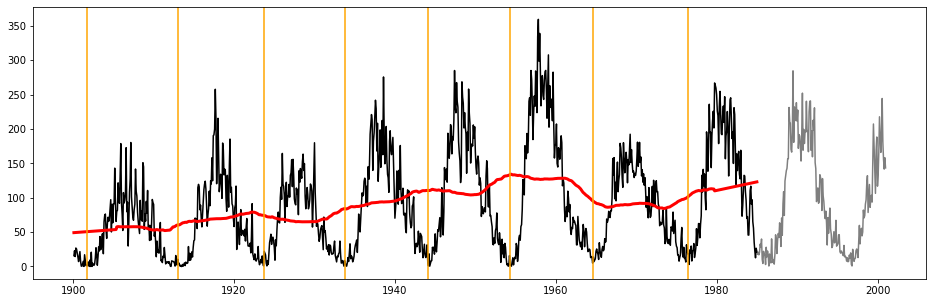

In [11]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k')
plt.plot(y_future,'k',alpha=0.5)
plt.plot(trend,'r',linewidth=3)
for low in lows:
    plt.axvline(x=pd.to_datetime(low),color='orange')

# Divide the detrended data into seasons

In [12]:
period = int(np.round(np.mean(np.diff(lows_index))))
num_seasons = len(lows)-1    

In [13]:
seasonals = np.empty((period,num_seasons))
for p in range(num_seasons):
    s = detrended[lows_index[p]:lows_index[p]+period]
    s = 2*(s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s
    
mean_seasonals = seasonals.mean(axis=1)

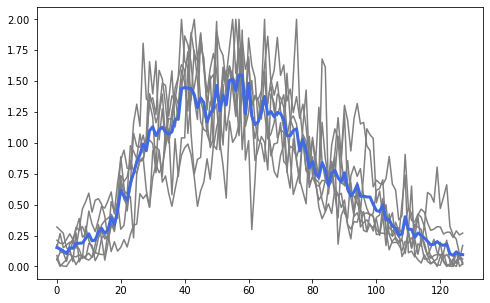

In [14]:
plt.figure(figsize=(8,5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3)

# Smooth the seasonal data

In [15]:
filt_size = 9
filt = np.repeat(1.0 / filt_size, filt_size)

seasonals = np.empty((period,num_seasons))
for p in range(num_seasons):
    s = detrended[lows_index[p]:lows_index[p]+period]
    s = convolution_filter(s, filt)
    s = extrapolate_trend(s, filt_size)
    s = (s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s
    
mean_seasonals = seasonals.mean(axis=1)

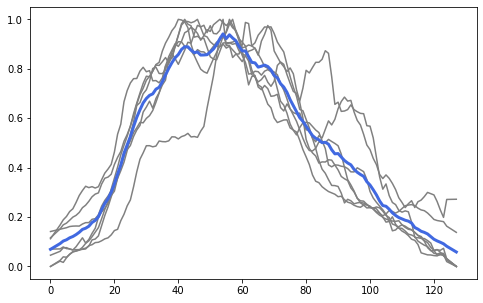

In [16]:
plt.figure(figsize=(8,5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3)

# Remove outliers

In [17]:
seasonals = seasonals[:,[2,3,4]]
mean_seasonals = seasonals.mean(axis=1)

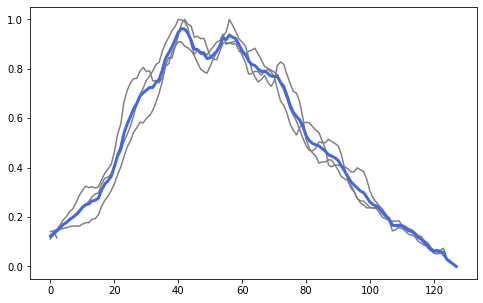

In [18]:
plt.figure(figsize=(8,5))
plt.plot(seasonals[0],color=0.5*np.ones(3),label='historical data')
plt.plot(seasonals,color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3)

# Build the seasonal template

In [19]:
seasonal = pd.Series(index=y_hist.index,data=0)

for low in lows_index:
    if low+period<len(seasonal):
        seasonal[low:low+period] = mean_seasonals
    else:
        seasonal[low:] = mean_seasonals[:len(seasonal)-(low+period)]
        
seasonal = seasonal / np.max(seasonal)

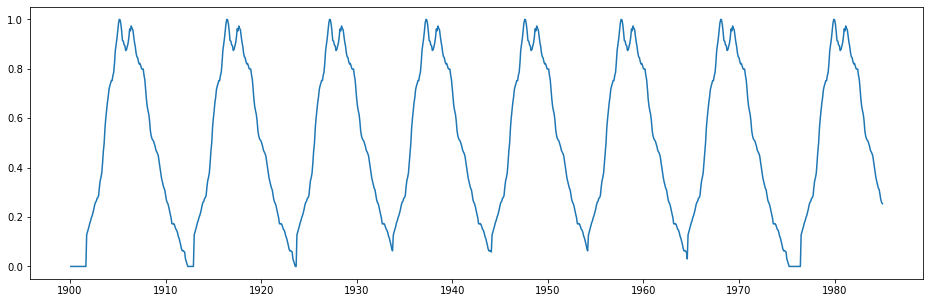

In [20]:
plt.figure(figsize=(16,5))
plt.plot(seasonal)

# Final model

In [21]:
season_and_trend = 2*trend*seasonal

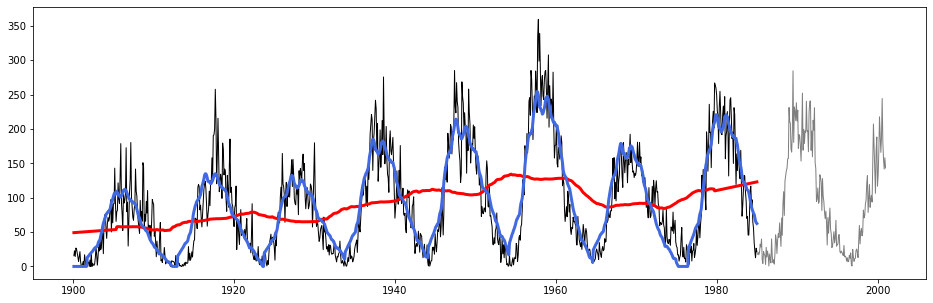

In [22]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='trend & seasonal',color='royalblue',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)

# Model residue

In [23]:
residue = y_hist - season_and_trend

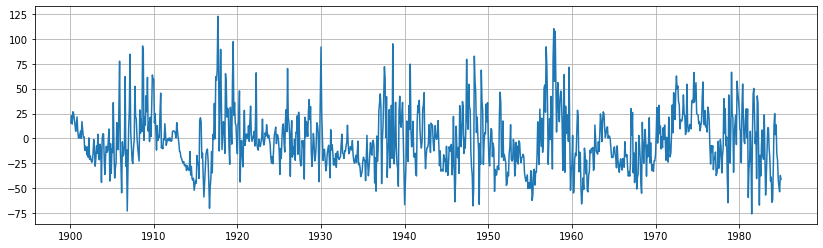

In [24]:
plt.figure(figsize=(14,4))
plt.plot(residue)
plt.grid()

## Size of the residue

In [25]:
MAEm = np.abs(residue).mean()
RMSEm = np.sqrt( np.square(residue).mean() )
MAEm, RMSEm

(22.72635908805391, 29.218041541672687)

## Stationarity of the residue

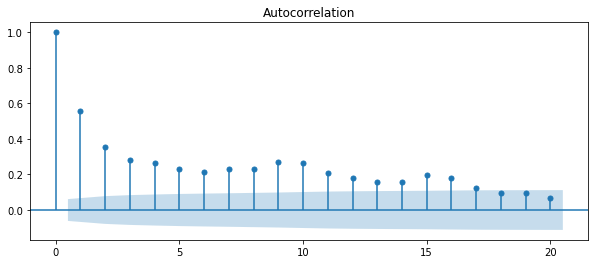

In [26]:
_, ax = plt.subplots(figsize=(10,4))
tsaplots.plot_acf(residue,lags=20, ax=ax)
plt.show()

# Forecast

In [27]:
f = len(y_future)
f_periods = int(1 + f/period)
yhat_trend = pd.Series(index=y_future.index, data=trend[-1])

In [28]:
yhat_seasonal = pd.Series(index=y_future.index)
for i in range(len(yhat_seasonal)):
    yhat_seasonal[i] = seasonal[-(f_periods*len(mean_seasonals)-i)]

/tmp/ipykernel_37025/401865666.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  yhat_seasonal = pd.Series(index=y_future.index)


In [29]:
yhat = 2*yhat_trend*yhat_seasonal

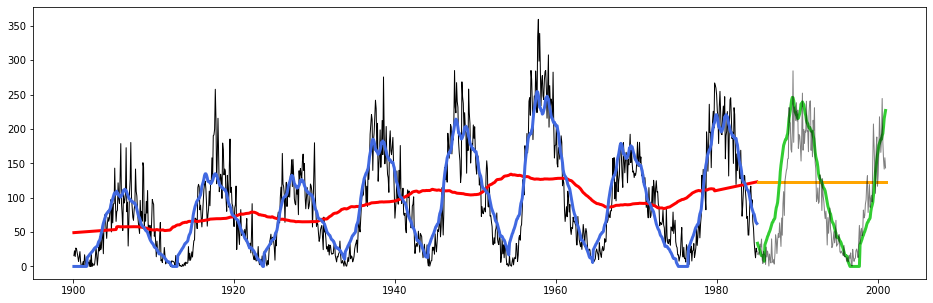

In [30]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='model',color='royalblue',linewidth=3)
plt.plot(yhat_trend,label='forecast trend',color='orange',linewidth=3)
plt.plot(yhat,label='forecast',color='limegreen',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)

## Prediction error

In [31]:
pred_error = y_future - yhat

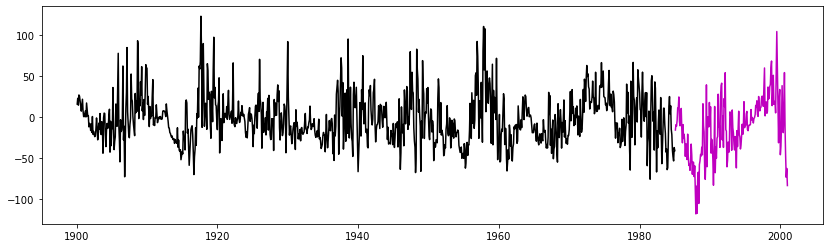

In [32]:
plt.figure(figsize=(14,4))
plt.plot(residue,'k')
plt.plot(pred_error,'m')

## Size of the predicition error

In [33]:
MAEp = np.abs(pred_error).mean()
RMSEp = np.sqrt( np.square(pred_error).mean() )
MAEp, RMSEp

(30.579767206745913, 39.012536197254114)

# save the result

In [38]:
import pickle

X = { 'history' : pd.DataFrame({'y_hist':y_hist ,'t_and_s':season_and_trend ,'ts_residue':residue}),
  'future': pd.DataFrame({'y_future':y_future , 'y_hat':yhat })
}
    
with open('decomp.pkl', 'wb') as file:
    pickle.dump(X,file)